Шорохов Илья Александрович
Telegram: @skarasique

# Прогнозирование музыкальной жанровой принадлежности

### План работы
- Открыть файлы с данными
- Проверить данные и откорректировать их, если потребуется.
- Провести исследовательский анализ представленных данных. Описать найденные особенности.
- Выберать метрику для обучения.
- Обучить разные модели и оцените их качество. Выбрать лучшую модель и проверить её на тестовой выборке.
- Написать общий вывод.

### Цель работы
- Разработать ML-модель, позволяющую классифицировать музыкальные произведения по жанрам.

### Описание данных
- instance_id -Уникальный идентификатор трека
- track_name - Название трека
- acousticness - Мера уверенности от 0,0 до 1,0 в том, что трек является акустическим. 1,0 означает высокую степень уверенности в том, что трек является акустическим.
- danceability - Танцевальность описывает, насколько трек подходит для танцев, основываясь на сочетании музыкальных элементов, включая темп, стабильность ритма, силу ударов и общую регулярность. Значение 0,0 означает наименьшую танцевальность, а 1,0 - наибольшую танцевальность.
- duration_ms - Продолжительность трека в миллисекундах.
- energy - Энергия это показатель от 0,0 до 1,0, представляющий собой меру интенсивности и активности. Как правило, энергичные композиции ощущаются как быстрые, громкие и шумные. Например, дэт-метал обладает высокой энергией, в то время как прелюдия Баха имеет низкую оценку этого параметра
- instrumentalness - Определяет, содержит ли трек вокал. Звуки "Ooh" и "aah" в данном контексте рассматриваются как инструментальные. Рэп или разговорные треки явно являются "вокальными". Чем ближе значение инструментальности к 1,0, тем больше вероятность того, что трек не содержит вокала
- key - базовый ключ (нота) произведения
- liveness - Определяет присутствие аудитории в записи. Более высокие значения liveness означают увеличение вероятности того, что трек был исполнен вживую. Значение выше 0,8 обеспечивает высокую вероятность того, что трек исполняется вживую
- loudness - Общая громкость трека в децибелах (дБ)
- mode - Указывает на модальность (мажорную или минорную) трека
- speechiness - Речевой характер определяет наличие в треке разговорной речи. Чем более исключительно речевой характер носит запись (например, ток-шоу, аудиокнига, поэзия), тем ближе значение атрибута к 1,0. Значения выше 0,66 характеризуют треки, которые, вероятно, полностью состоят из разговорной речи. Значения от 0,33 до 0,66 характеризуют треки, которые могут содержать как музыку, так и речь, как в виде фрагментов, так и в виде слоев, включая такие случаи, как рэп-музыка. Значения ниже 0,33, скорее всего, представляют музыку и другие неречевые треки.
- tempo - Темп трека в ударах в минуту (BPM). В музыкальной терминологии темп представляет собой скорость или темп данного произведения и напрямую зависит от средней продолжительности тактов
- obtained_date - дата загрузки в сервис
- valence - Показатель от 0,0 до 1,0, характеризующий музыкальный позитив, передаваемый треком. Композиции с высокой валентностью звучат более позитивно (например, радостно, весело, эйфорично), а композиции с низкой валентностью - более негативно (например, грустно, депрессивно, сердито)
- music_genre - Музыкальный жанр трека

# Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)

In [2]:
data = pd.read_csv('/kaggle/input/music-genre-competition/kaggle_music_genre_train.csv/kaggle_music_genre_train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [3]:
data_test = pd.read_csv('/kaggle/input/music-genre-competition/kaggle_music_genre_test.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [4]:
print('Размер датасета до чистки:', data.shape)

Размер датасета до чистки: (20394, 16)


- нужно посмотреть на колонки key, mode, tempo. там есть пропуски

- obtained_date скорее всего не даст нам никакой существенной информации для модели, удалить?

- key, он же тональность, тоже не скажется на обучаемости модели, удалить?

- loudness, она же громкость возможно поможет выделить условную принадлежность к жанру, т.к. есть гипотеза о том, что танцевальная музыка имеет более высокий уровень loudness, чем, например, тяжелая музыка, где микс перегружен в плане ачх. но опять же, взаимосвязь будет скорее условная, т.к. уровень громкости напрямую не связан с жанром из-за стандартов стриминговых сервисов. Таким образом, например, для Spotify таргет по громкости -14.0 LUFS, и все, что громче автоматически делается тише. Здесь бы еще понять, данные по громкости предоставлены до загрузки на стриминг или после?

- судя по графикам на странице соревнования, в duration_ms есть отрицательные значения, которых в принципе быть не должно. ошибка? нужно посмотреть, примеры таких треков, попытаться понять, с чем связаны отрицательные значения в длительно. возможно есть смысл заменить эти значения на среднее или медиану. график построю при проверке

In [5]:
print(data.duplicated().value_counts())

False    20394
Name: count, dtype: int64


дублей нет

In [6]:
data['key'].unique().tolist() #посмотрим есть ли уникальный дубли в столбце

['D', 'A', 'E', 'G#', 'C', 'D#', 'A#', 'F', 'F#', nan, 'G', 'C#', 'B']

дублей тут нет, но есть пропуски, к ним вернемся позже

In [7]:
data['mode'].unique().tolist() #проверим дубли в этом столбце

['Major', 'Minor', nan]

аналогично, дублей нет, есть пропуски, вернемся к ним позже

In [8]:
data['music_genre'].unique().tolist()

['Country',
 'Rock',
 'Alternative',
 'Hip-Hop',
 'Blues',
 'Jazz',
 'Electronic',
 'Anime',
 'Rap',
 'Classical']

здесь тоже дублей нет. идем дальше.

In [9]:
data = data.drop(['obtained_date'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  valence           20394 non-null  float64
 14  music_genre       20394 non-null  object 
dtypes: float64(11), object(4)
memory usage: 2.3+ MB


посмотрим на пропуски в столбцах key, mode, tempo


In [10]:
missing_rows = data[data['key'].isnull()]
display(missing_rows)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
26,87453.0,"Serenade in B flat, K.361 ""Gran partita"": 3. A...",0.9910,0.154,-1.0,0.0384,0.902000,NaN,0.1090,-26.909,Major,0.0405,68.199,0.0393,Classical
49,87796.0,Star67,0.7470,0.478,294973.0,0.3950,0.000005,NaN,0.2640,-7.917,Major,0.2130,74.515,0.1700,Hip-Hop
60,69398.0,Sleep On The Floor,0.2490,0.389,211851.0,0.4310,0.000000,NaN,0.1300,-8.061,Major,0.0344,142.140,0.2750,Rock
75,20134.0,Rogue,0.0145,0.580,201694.0,0.7200,0.598000,NaN,0.2810,-5.541,Major,0.0638,143.816,0.1600,Electronic
107,69505.0,Party Song,0.1560,0.563,191760.0,0.8970,0.000000,NaN,0.3520,-4.996,Major,0.2130,157.803,0.7790,Country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20312,50054.0,Dance with Me,0.5510,0.565,180480.0,0.3920,0.000106,NaN,0.2470,-10.083,Major,0.0268,98.485,0.4930,Country
20359,24889.0,Ho's,0.0560,0.850,207693.0,0.4360,0.000019,NaN,0.2960,-9.080,Major,0.0510,87.711,0.7700,Rock
20361,62172.0,"Bokurano Eien - Nando Umarekawattemo,Te Wo Tsu...",0.2710,0.581,324667.0,0.7920,0.000000,NaN,0.0993,-2.885,Major,0.0249,127.915,0.5700,Anime
20377,85249.0,Dreaming of Fiji,0.9750,0.162,114827.0,0.0395,0.979000,NaN,0.1050,-29.746,Minor,0.0427,109.043,0.0378,Classical


заполнить пропуски каким-то логичным значением не получится, т.к. взять эту информацию из других столбцов нет возможности, а пытаться вычленить гармонию по названию трека слишком затратно. пропусков всего 735 штук, можно от этих строк избавиться. Вернемся к этому позже, пока что посмотрим на пропуски в других столбцах

In [11]:
missing_rows_mode = data[data['mode'].isnull()]
display(missing_rows_mode)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
96,63867.0,"Clarinet Concerto No. 1 in F Minor, Op. 73, J....",0.973000,0.416,401000.0,0.0735,0.710000,F,0.0781,-20.723,NaN,0.0411,112.006,0.2220,Classical
129,75913.0,"Concerto for Viola d'amore, Lute, Strings and ...",0.926000,0.495,-1.0,0.1110,0.120000,C#,0.0772,-18.591,NaN,0.0506,78.772,0.4360,Classical
131,64391.0,She Keeps The Home Fires Burning,0.526000,0.731,236173.0,0.6080,0.000000,G,0.1260,-10.690,NaN,0.0267,126.263,0.7450,Country
292,37649.0,Ven - Continuous Mix,0.000216,0.555,50472.0,0.9530,0.059400,E,0.8180,-4.411,NaN,0.1090,114.885,0.3030,Electronic
326,43825.0,Wicked As It Seems,0.287000,0.689,285263.0,0.6200,0.000002,G,0.0368,-10.601,NaN,0.0339,110.860,0.9620,Blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20265,65040.0,Indestructible,0.041500,0.674,226413.0,0.6110,0.000001,D,0.0726,-6.322,NaN,0.0363,175.929,0.7820,Rock
20272,85638.0,I'm Waiting For The Man - Album Version (Stereo),0.029700,0.675,279520.0,0.6410,0.863000,G,0.1440,-9.754,NaN,0.0427,125.891,0.8540,Rock
20294,32079.0,Day Sixteen: Loser,0.006170,0.479,286373.0,0.7300,0.000007,B,0.5630,-9.424,NaN,0.0352,94.501,0.2440,Classical
20304,79390.0,Dancing Reflections,0.941000,0.203,334237.0,0.0778,0.702000,NaN,0.1630,-18.531,NaN,0.0335,91.704,0.0564,Anime


Аналогичная ситуация. Количество пропусков небольшое (506 строк). Заполнить значения нечем. Пока что единственный логичный вариант, это избавиться от строк.

In [12]:
missing_rows_tempo = data[data['tempo'].isnull()]
display(missing_rows_tempo)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
63,45966.0,Back Door Man,0.287000,0.476,212427.0,0.612,0.000252,A,0.0877,-7.010,Major,0.0335,NaN,0.909,Rock
85,90217.0,familia,0.000059,0.489,269000.0,0.947,0.000000,C#,0.1130,-3.925,Minor,0.0419,NaN,0.517,Anime
114,79170.0,Poor Johnny,0.348000,0.698,362267.0,0.800,0.000087,B,0.4430,-3.091,Minor,0.0284,NaN,0.654,Blues
138,39716.0,Set Free (feat. Yael),0.008340,0.776,191210.0,0.783,0.044900,C,0.0377,-3.595,Major,0.0374,NaN,0.943,Electronic
145,48590.0,Running Away,0.001100,0.608,178440.0,0.801,0.000008,A,0.2230,-5.452,Minor,0.0376,NaN,0.544,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19929,57285.0,Letting You Go,0.008770,0.459,223655.0,0.903,0.000000,F,0.1680,-4.649,Minor,0.0673,NaN,0.364,Alternative
19988,72399.0,My Prerogative,0.065500,0.762,291560.0,0.625,0.000000,A,0.2520,-10.481,Major,0.0562,NaN,0.696,Rap
20138,31698.0,Angelina,0.508000,0.637,-1.0,0.486,0.000065,A,0.1770,-11.681,Major,0.0695,NaN,0.860,Blues
20212,54647.0,Chaos and Clothes,0.784000,0.560,214945.0,0.204,0.000000,F,0.1090,-15.395,Major,0.0448,NaN,0.282,Alternative


То же самое. В теории, можно было бы создать отдельную модель под определения темпа на основе данных, например, по сталбцу dancebility, но, кажется, что из-за 442 строк, этого делать смысла нет.

Итого: удаляем все строки с пропусками в столбцах key, mode и tempo

In [13]:
data = data.dropna()
print('Размер датасета после чистки:', data.shape)

Размер датасета после чистки: (18754, 15)


In [14]:
# проделываем с тестовым набором данных то же самое, что и с основным -- удаляем пропуски, лишний столбец
print('Размер датасета до чистки:', data_test.shape)
data_test = data_test.drop(['obtained_date'], axis=1)

print('Размер датасета после чистки:', data_test.shape)

Размер датасета до чистки: (5099, 15)
Размер датасета после чистки: (5099, 14)


In [15]:
data_test = data_test.dropna()

In [16]:
print('Размер датасета после чистки:', data_test.shape)

Размер датасета после чистки: (4681, 14)


In [17]:
# Преобразуем тип столбцов с категориальными признаками
data['key'] = data['key'].astype('category')
data['mode'] = data['mode'].astype('category')

In [18]:
data_test['key'] = data_test['key'].astype('category')
data_test['mode'] = data_test['mode'].astype('category')

In [19]:
data_test['instance_id'] = data_test['instance_id'].astype('float64')

In [20]:
data_test.dtypes

instance_id          float64
track_name            object
acousticness         float64
danceability         float64
duration_ms          float64
energy               float64
instrumentalness     float64
key                 category
liveness             float64
loudness             float64
mode                category
speechiness          float64
tempo                float64
valence              float64
dtype: object

In [21]:
data.dtypes

instance_id          float64
track_name            object
acousticness         float64
danceability         float64
duration_ms          float64
energy               float64
instrumentalness     float64
key                 category
liveness             float64
loudness             float64
mode                category
speechiness          float64
tempo                float64
valence              float64
music_genre           object
dtype: object

In [22]:
print('Размер тренировочного датасета:', data.shape)
print('Размер тестового датасета:', data_test.shape)

Размер тренировочного датасета: (18754, 15)
Размер тестового датасета: (4681, 14)


In [23]:
# удалим также столбцы track_name, а в качестве идентификаторов оставим instance_id
data = data.drop(['track_name'], axis=1)
data_test = data_test.drop(['track_name'], axis=1)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18754 entries, 0 to 20393
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   instance_id       18754 non-null  float64 
 1   acousticness      18754 non-null  float64 
 2   danceability      18754 non-null  float64 
 3   duration_ms       18754 non-null  float64 
 4   energy            18754 non-null  float64 
 5   instrumentalness  18754 non-null  float64 
 6   key               18754 non-null  category
 7   liveness          18754 non-null  float64 
 8   loudness          18754 non-null  float64 
 9   mode              18754 non-null  category
 10  speechiness       18754 non-null  float64 
 11  tempo             18754 non-null  float64 
 12  valence           18754 non-null  float64 
 13  music_genre       18754 non-null  object  
dtypes: category(2), float64(11), object(1)
memory usage: 1.9+ MB


In [25]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4681 entries, 0 to 5098
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   instance_id       4681 non-null   float64 
 1   acousticness      4681 non-null   float64 
 2   danceability      4681 non-null   float64 
 3   duration_ms       4681 non-null   float64 
 4   energy            4681 non-null   float64 
 5   instrumentalness  4681 non-null   float64 
 6   key               4681 non-null   category
 7   liveness          4681 non-null   float64 
 8   loudness          4681 non-null   float64 
 9   mode              4681 non-null   category
 10  speechiness       4681 non-null   float64 
 11  tempo             4681 non-null   float64 
 12  valence           4681 non-null   float64 
dtypes: category(2), float64(11)
memory usage: 448.5 KB


## Промежуточный вывод

- Предобработка данных проведена
- Удалены строки с пропусками, которые не было возможности заполнить
- Дубли не найдены
- Удален столбец с датой, который никак не повлияет на обучаемость модели и столбец с названием трека
- Преобразован типы столбцов на категориальные там, где это было необходимо

# EDA

Для начала посмотрим значения в столбце с длительностью трека

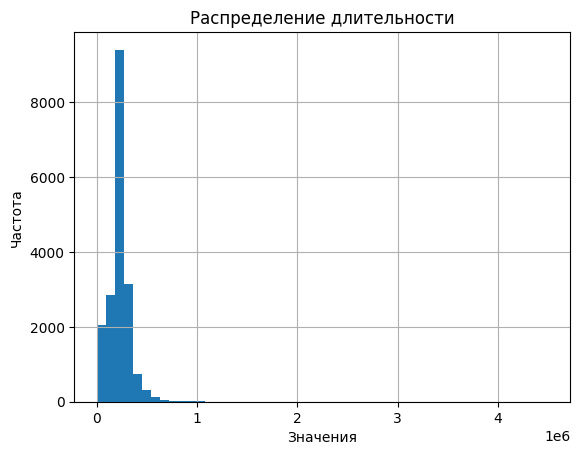

In [26]:
plt.hist(data['duration_ms'], bins=50)

plt.title('Распределение длительности')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

In [27]:
data['duration_ms'].value_counts()

duration_ms
-1.0         1840
 240000.0      15
 192000.0      13
 180000.0      12
 191000.0       9
             ... 
 248440.0       1
 198286.0       1
 142213.0       1
 368083.0       1
 271885.0       1
Name: count, Length: 12791, dtype: int64

In [28]:
duration_error = data[data['duration_ms'] == -1]

In [29]:
display(duration_error)

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
13,73565.0,0.11000,0.470,-1.0,0.6410,0.000000,F#,0.1550,-7.454,Major,0.0658,86.387,0.638,Anime
35,76827.0,0.08480,0.748,-1.0,0.7120,0.000000,D,0.1320,-5.651,Major,0.1430,140.055,0.180,Rap
50,43888.0,0.05400,0.482,-1.0,0.6270,0.000003,D,0.1110,-5.779,Major,0.0300,95.903,0.170,Alternative
55,39574.0,0.90900,0.374,-1.0,0.2270,0.000069,A#,0.6860,-18.719,Major,0.0579,78.236,0.264,Classical
59,42479.0,0.04810,0.615,-1.0,0.7790,0.000000,C,0.2300,-9.577,Major,0.0832,147.987,0.899,Country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20345,51087.0,0.90900,0.283,-1.0,0.1330,0.800000,B,0.0927,-25.586,Minor,0.0412,116.376,0.177,Classical
20353,48460.0,0.00298,0.450,-1.0,0.9150,0.446000,F,0.7710,-1.404,Minor,0.2360,137.948,0.156,Electronic
20357,23677.0,0.98200,0.372,-1.0,0.1590,0.000001,G,0.1650,-21.129,Major,0.0364,135.617,0.512,Classical
20358,89832.0,0.96600,0.638,-1.0,0.0689,0.000001,E,0.1020,-16.222,Major,0.0659,120.160,0.695,Blues


Отрицательные значения можно заменить на медиану

In [30]:
data.loc[data['duration_ms'] == -1, 'duration_ms'] = data['duration_ms'].median()

In [31]:
data['duration_ms'].value_counts()

duration_ms
219709.5    1840
240000.0      15
192000.0      13
180000.0      12
191000.0       9
            ... 
248440.0       1
198286.0       1
142213.0       1
368083.0       1
271885.0       1
Name: count, Length: 12791, dtype: int64

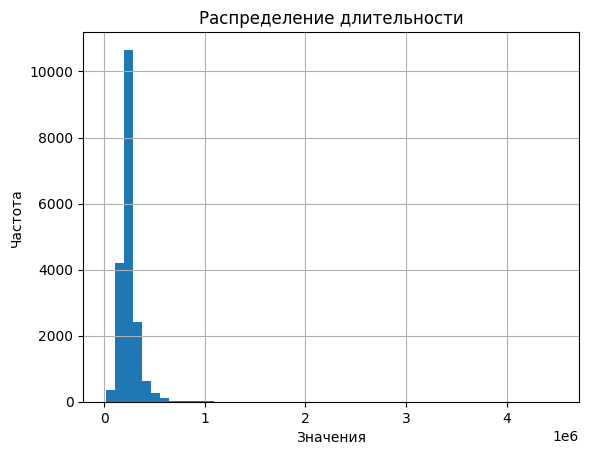

In [32]:
plt.hist(data['duration_ms'], bins=50)

plt.title('Распределение длительности')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

От аномалии в длительности избавились. Можно идти дальше

In [33]:
data['acousticness'].value_counts()

acousticness
0.994000    72
0.995000    72
0.992000    53
0.991000    51
0.993000    51
            ..
0.000498     1
0.000053     1
0.000012     1
0.000067     1
0.000008     1
Name: count, Length: 3559, dtype: int64

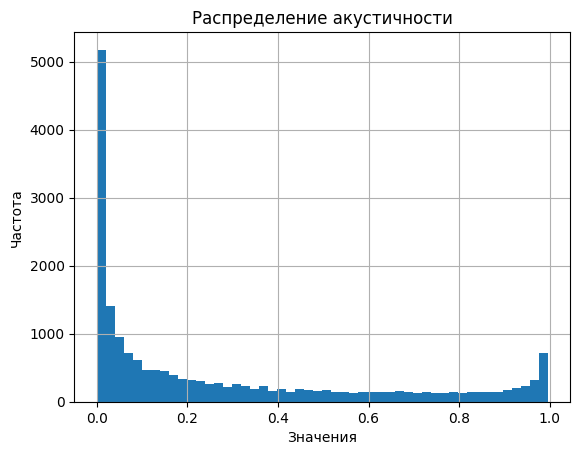

In [34]:
plt.hist(data['acousticness'], bins=50)

plt.title('Распределение акустичности')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

Множество значений возле 0 говорит о том, что большая часть треков не акустичная. Не думаю, что это аномалия

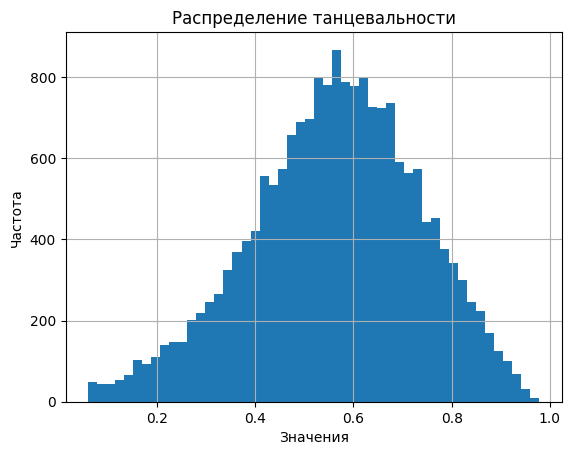

In [35]:

plt.hist(data['danceability'], bins=50)

plt.title('Распределение танцевальности')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

Здесь имеем более норамально распределение по сравнению с акустичностью. Аномалий нет, среднее значение около 0.5, что логично

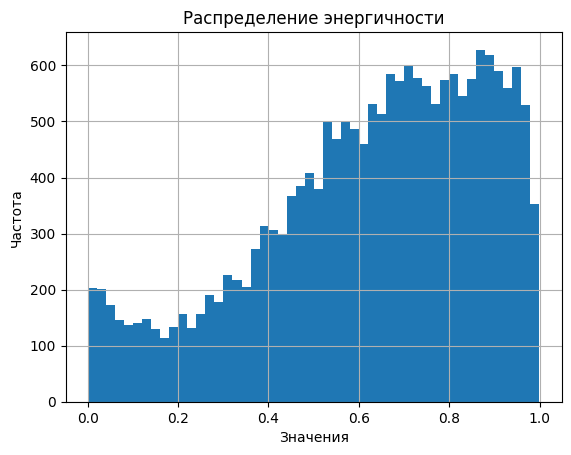

In [36]:

plt.hist(data['energy'], bins=50)

plt.title('Распределение энергичности')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

распределение смещено к 1, есть значения возле 0, можно посмотреть их поближе, но скорее всего это не аномалия

In [37]:
data['energy'].value_counts()

energy
0.87300    45
0.85900    43
0.86000    42
0.95000    42
0.56900    41
           ..
0.03080     1
0.00887     1
0.07930     1
0.06960     1
0.01470     1
Name: count, Length: 1492, dtype: int64

Редкие знаечения возле 0, такое тоже имеет место быть, так как датасет содержит разную музыку

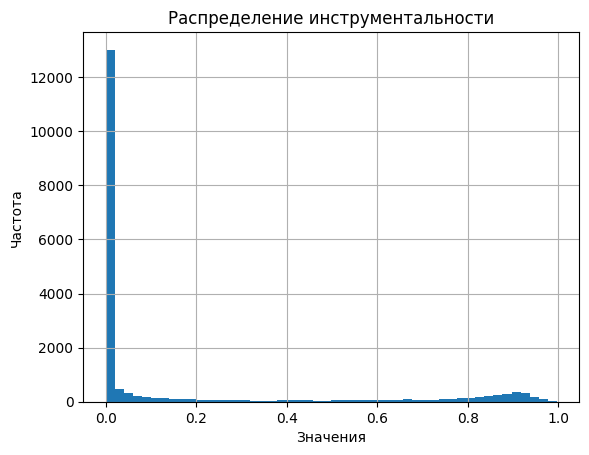

In [38]:

plt.hist(data['instrumentalness'], bins=50)

plt.title('Распределение инструментальности')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

Пик возле 0, либо это аномалия, либо почти все треки в датасете не инструментальные, что более логично. Проверим

In [39]:
data['instrumentalness'].value_counts()

instrumentalness
0.000000    5492
0.898000      25
0.905000      25
0.912000      24
0.884000      23
            ... 
0.000813       1
0.022400       1
0.086700       1
0.000005       1
0.003410       1
Name: count, Length: 4235, dtype: int64

In [40]:
not_instrumental = data[data['instrumentalness'] == 0]
display(not_instrumental)

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
2,87888.0,0.228000,0.454,173448.0,0.804,0.0,E,0.181,-5.225,Minor,0.3710,80.980,0.344,Alternative
10,78664.0,0.315000,0.789,252040.0,0.621,0.0,A#,0.136,-7.685,Minor,0.2830,118.891,0.158,Hip-Hop
13,73565.0,0.110000,0.470,219709.5,0.641,0.0,F#,0.155,-7.454,Major,0.0658,86.387,0.638,Anime
15,85051.0,0.182000,0.840,182400.0,0.193,0.0,G#,0.173,-11.186,Major,0.0696,99.990,0.204,Alternative
18,73394.0,0.006180,0.554,219800.0,0.849,0.0,F,0.305,-4.692,Minor,0.0548,135.999,0.511,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20381,43672.0,0.000525,0.905,192840.0,0.677,0.0,D,0.251,-7.987,Major,0.3450,140.882,0.598,Rap
20383,62820.0,0.232000,0.697,201453.0,0.794,0.0,D,0.331,-5.109,Major,0.0444,103.031,0.689,Country
20384,64571.0,0.072400,0.721,267973.0,0.666,0.0,C#,0.217,-8.226,Major,0.0662,97.998,0.323,Hip-Hop
20387,74390.0,0.638000,0.663,283733.0,0.758,0.0,G#,0.257,-6.554,Major,0.0386,174.794,0.961,Jazz


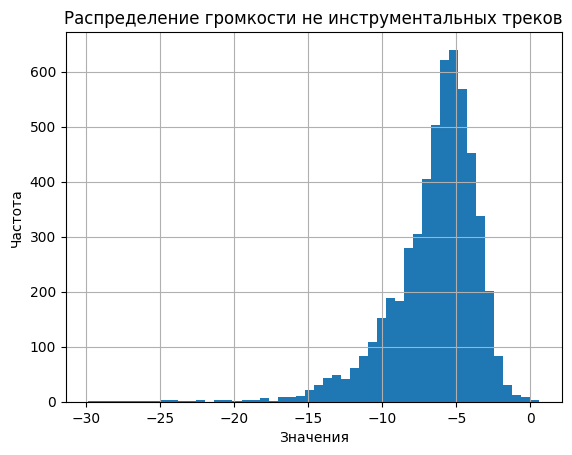

In [41]:
plt.hist(not_instrumental['loudness'], bins=50)

plt.title('Распределение громкости не инструментальных треков')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

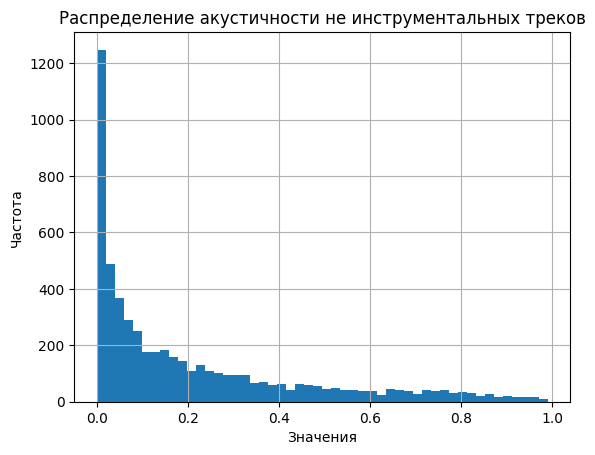

In [42]:
plt.hist(not_instrumental['acousticness'], bins=50)

plt.title('Распределение акустичности не инструментальных треков')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

Судя по распределениям громкости и акустичности, аномалий нет. Все треки не акустичные и достаточно громкие. Идем к следующему столбцу

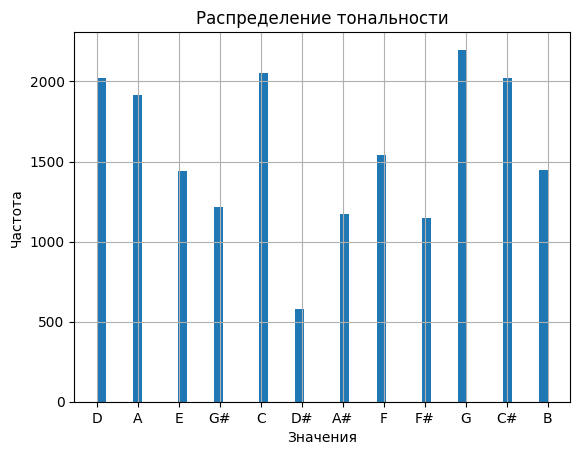

In [43]:
plt.hist(data['key'], bins=50)

plt.title('Распределение тональности')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

Самая непопулярная тональноть - Ре диез (D#). Самая популярная - Соль (G)

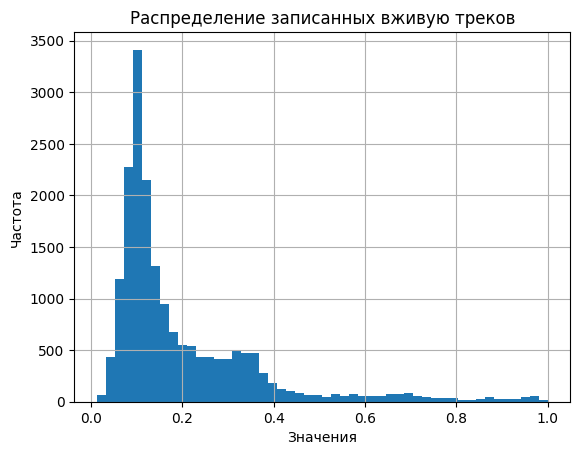

In [44]:

plt.hist(data['liveness'], bins=50)

plt.title('Распределение записанных вживую треков')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

Судя по графику выше, большая часть треков не живое исполнение. Выше 0.4 лишь малая часть всего списка.

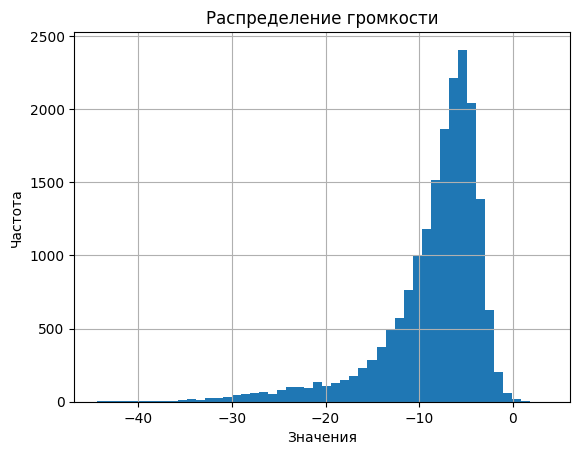

In [45]:

plt.hist(data['loudness'], bins=50)

plt.title('Распределение громкости')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

In [46]:
data['loudness'].describe()

count    18754.000000
mean        -8.553494
std          5.505285
min        -44.406000
25%        -10.254750
50%         -7.044000
75%         -5.052250
max          3.744000
Name: loudness, dtype: float64

Большая часть треков имеет громкость в диапазоне от -12 до -3 дб . В среднем, громкость трека составляет -8.5 дб.

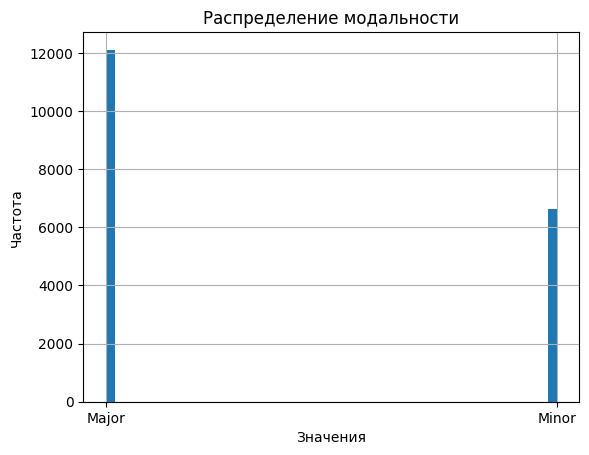

In [47]:
plt.hist(data['mode'], bins=50)

plt.title('Распределение модальности')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

Песен с мажорным настроением больше чем с минорным почти в два раза.

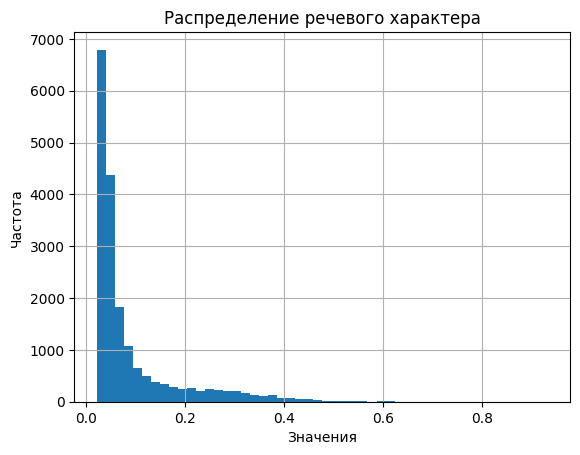

In [48]:

plt.hist(data['speechiness'], bins=50)

plt.title('Распределение речевого характера')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

Большая часть треков, это музыка, диапазон от 0 до 0.1. Меньше всего смежных треков и не музыкальных композиций.

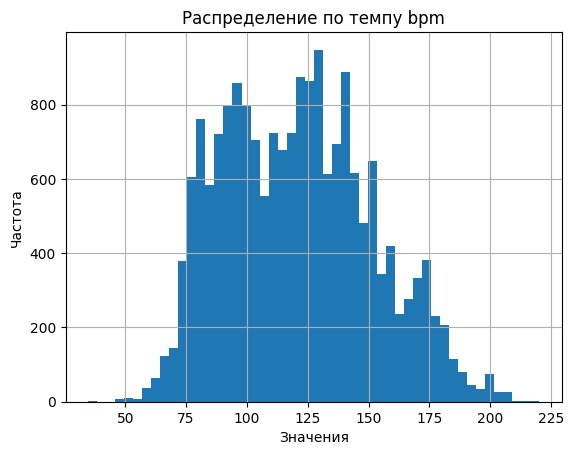

In [49]:
plt.hist(data['tempo'], bins=50)

plt.title('Распределение по темпу bpm')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

In [50]:
data['tempo'].describe()

count    18754.000000
mean       120.929143
std         30.423797
min         34.765000
25%         95.937250
50%        120.011000
75%        141.949000
max        220.041000
Name: tempo, dtype: float64

В среднем темп песни составляет 120 bpm, самое низкое значение 34 bpm, самое высокое 220 bpm. Скорее всего 220 bpm это тяжелая музка, а 34 bpm, это аудиокнига или что-то из экспериментальных жанров.

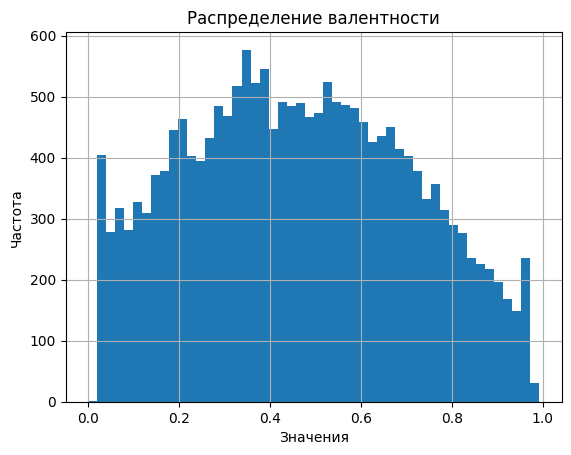

In [51]:
plt.hist(data['valence'], bins=50)

plt.title('Распределение валентности')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

In [52]:
data['valence'].describe()

count    18754.000000
mean         0.464954
std          0.243685
min          0.000000
25%          0.272000
50%          0.457000
75%          0.654000
max          0.992000
Name: valence, dtype: float64

Есть как веселые и позитивные песни, так и очень грустные и депрессивные. Большая часть песен находится где-то посередине, т.е. не имеет ярко выраженного настроения.

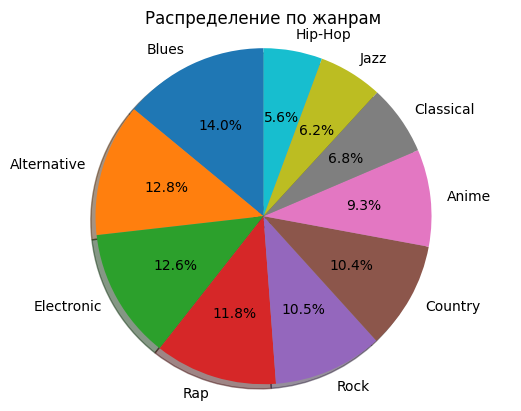

In [53]:

column_data = data['music_genre']

value_counts = column_data.value_counts()

labels = value_counts.index.tolist()
sizes = value_counts.values.tolist()

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')

plt.title('Распределение по жанрам')

plt.show()

Из диаграммы выше видно, что преобладают такаи жанры как блюз, альтренативная музыка, электроника и рэп. Наименее популярны хип-хоп, джаз и классическая музыка.

## Промежуточный вывод
- Большая часть треков не акустичная
- Была найдена и устранена аномалия в столбце с длительностью треков
- Среднее значение танцевальности около 0.5
- Распределение энергичности смещено к 1, есть небольшое скопление значений возле 0
- На графике инструментальности пик возле 0,это значит, что почти все треки в датасете не инструментальные
- Самая непопулярная тональноть - Ре диез (D#). Самая популярная - Соль (G)
- Большая часть треков не живое исполнение. Выше 0.4 лишь малая часть всего списка.
- Большая часть треков имеет громкость в диапазоне от -12 до -3 дб . В среднем, громкость трека составляет -8.5 дб
- В среднем темп песни составляет 120 bpm, самое низкое значение 34 bpm, самое высокое 220 bpm. Скорее всего 220 bpm это тяжелая музка, а 34 bpm, это аудиокнига или что-то из экспериментальных жанров
- Песен с мажорным настроением больше чем с минорным почти в два раза
- Большая часть треков, это музыка, диапазон от 0 до 0.1. Меньше всего смежных треков и не музыкальных композиций
- В среднем темп песни составляет 120 bpm, самое низкое значение 34 bpm, самое высокое 220 bpm. Скорее всего 220 bpm это тяжелая музка, а 34 bpm, это аудиокнига или что-то из экспериментальных жанров
- Есть как веселые и позитивные песни, так и очень грустные и депрессивные. Большая часть песен находится где-то посередине, т.е. не имеет ярко выраженного настроения
- Преобладают такаи жанры как блюз, альтренативная музыка, электроника и рэп. Наименее популярны хип-хоп, джаз и классическая музыка

# Формулировка ML-задачи
- Целевой признак в данном случае столбец music_genre.
- Цель: разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.
- Метрика: F1-мера точности модели

# Тестирование моделей

В данном случае мы решаем задачу классификации, поэтому будем тестировать деревянные модели -- случайный лес, градиентный бустинг. Начнем с первой

In [54]:
# выделяем признаки и целевой признак
X = data.drop('music_genre', axis=1)
y = data['music_genre'] 

In [55]:
# Создаем объект LabelEncoder, чтобы закодировать целевой признак
le = LabelEncoder()

In [56]:
# Кодируем целевой признак
y_encoded = le.fit_transform(y)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [58]:
# Преобразование признаков с использованием ColumnTransformer и объединение в пайплайн
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['acousticness', 'danceability', 'duration_ms', 'energy', 
                                   'instrumentalness', 'liveness', 'loudness', 'speechiness',
                                   'tempo', 'valence']),
        ('cat', OneHotEncoder(sparse_output=False), ['key', 'mode'])
    ]
)

In [59]:
# Обработка признаков
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [60]:
# Применение SMOTE к обучающей выборке
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

In [61]:
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))  # Классификатор Random Forest
])

# Задаем сетку параметров для GridSearchCV
parameters = {
    'classifier__n_estimators': [10, 30, 50],
    'classifier__max_depth': [10, 20]
}

In [62]:
# Создание объекта GridSearchCV
gridsearch = GridSearchCV(pipeline, parameters, cv=5)

In [63]:
# Обучение модели
gridsearch.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [10, 20],
                         'classifier__n_estimators': [10, 30, 50]})

In [64]:
# Лучшие параметры модели
print('Лучшие параметры модели:', gridsearch.best_params_)

Лучшие параметры модели: {'classifier__max_depth': 20, 'classifier__n_estimators': 50}


In [65]:
print('Лучшая метрика:',gridsearch.best_score_)

Лучшая метрика: 0.6021337126600284


In [66]:
# Прогнозы на тестовой выборке
y_pred = gridsearch.predict(X_test_processed)

# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 2.279125566515596


In [73]:
# Попробуем модель градиентного бустинга
pipeline_cb = Pipeline([
    ('catboost', CatBoostClassifier())  # градиентный бустинг CatboosClassifier
])
params_cb = {
    'catboost__learning_rate': [0.1, 0.01],
    'catboost__n_estimators': [10, 30, 50],
    'catboost__max_depth': [10, 20]
}

In [74]:
grid_cb = GridSearchCV(pipeline_cb, params_cb, cv=5)

In [75]:
# Обучение модели
grid_cb.fit(X_train_resampled, y_train_resampled)

0:	learn: 2.1710547	total: 475ms	remaining: 4.28s
1:	learn: 2.0733631	total: 901ms	remaining: 3.6s
2:	learn: 1.9852452	total: 1.32s	remaining: 3.08s
3:	learn: 1.9117966	total: 1.74s	remaining: 2.61s
4:	learn: 1.8521618	total: 2.16s	remaining: 2.16s
5:	learn: 1.7995722	total: 2.58s	remaining: 1.72s
6:	learn: 1.7544457	total: 3s	remaining: 1.29s
7:	learn: 1.7138711	total: 3.42s	remaining: 855ms
8:	learn: 1.6756719	total: 3.84s	remaining: 427ms
9:	learn: 1.6397945	total: 4.26s	remaining: 0us
0:	learn: 2.1724231	total: 423ms	remaining: 3.81s
1:	learn: 2.0686135	total: 848ms	remaining: 3.39s
2:	learn: 1.9860634	total: 1.27s	remaining: 2.96s
3:	learn: 1.9135516	total: 1.72s	remaining: 2.58s
4:	learn: 1.8528556	total: 2.3s	remaining: 2.3s
5:	learn: 1.8033289	total: 2.87s	remaining: 1.91s
6:	learn: 1.7583003	total: 3.42s	remaining: 1.46s
7:	learn: 1.7166154	total: 3.9s	remaining: 974ms
8:	learn: 1.6784383	total: 4.33s	remaining: 481ms
9:	learn: 1.6431857	total: 4.75s	remaining: 0us
0:	learn: 2

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_w

0:	learn: 2.1624748	total: 450ms	remaining: 22.1s
1:	learn: 2.0641616	total: 905ms	remaining: 21.7s
2:	learn: 1.9842039	total: 1.36s	remaining: 21.3s
3:	learn: 1.9126793	total: 1.82s	remaining: 21s
4:	learn: 1.8558303	total: 2.33s	remaining: 21s
5:	learn: 1.8027091	total: 2.78s	remaining: 20.4s
6:	learn: 1.7561691	total: 3.23s	remaining: 19.9s
7:	learn: 1.7151877	total: 3.69s	remaining: 19.3s
8:	learn: 1.6784317	total: 4.13s	remaining: 18.8s
9:	learn: 1.6411039	total: 4.58s	remaining: 18.3s
10:	learn: 1.6116817	total: 5.03s	remaining: 17.8s
11:	learn: 1.5829040	total: 5.47s	remaining: 17.3s
12:	learn: 1.5598665	total: 5.92s	remaining: 16.8s
13:	learn: 1.5386752	total: 6.37s	remaining: 16.4s
14:	learn: 1.5180012	total: 6.82s	remaining: 15.9s
15:	learn: 1.4959327	total: 7.27s	remaining: 15.4s
16:	learn: 1.4784459	total: 7.71s	remaining: 15s
17:	learn: 1.4596495	total: 8.16s	remaining: 14.5s
18:	learn: 1.4420660	total: 8.6s	remaining: 14s
19:	learn: 1.4248181	total: 9.05s	remaining: 13.6s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x7ece4d257e20>)]),
             param_grid={'catboost__learning_rate': [0.1, 0.01],
                         'catboost__max_depth': [10, 20],
                         'catboost__n_estimators': [10, 30, 50]})

In [78]:
# Лучшие параметры модели
print('Лучшие параметры модели:', grid_cb.best_params_)
print('Лучшая метрика:',grid_cb.best_score_)

Лучшие параметры модели: {'catboost__learning_rate': 0.1, 'catboost__max_depth': 10, 'catboost__n_estimators': 50}
Лучшая метрика: 0.5180654338549076


In [79]:
# Прогнозы на тестовой выборке
y_pred_cb = grid_cb.predict(X_test_processed)

# Оценка модели
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_cb))

Mean Absolute Error: 2.2167422020794456


In [80]:
# метрики модели случайного леса выше, остановися на ней
# получим предсказания на тестовых данных
# Преобразование тестовых данных с использованием preprocessor
X_new_processed = preprocessor.transform(data_test)

# Получение предсказаний для новых данных
y_pred_new = gridsearch.predict(X_new_processed)

In [81]:
# Декодируем прогнозы модели
y_pred_decoded = le.inverse_transform(y_pred_new)

In [82]:
# Оформляем предсказания в датафрейм
predictions = pd.DataFrame({'instance_id': data_test['instance_id'], 'music_genre': y_pred_decoded})

In [83]:
predictions.head()

,instance_id,music_genre
0,48564.0,Hip-Hop
1,72394.0,Country
2,88081.0,Rap
3,78331.0,Country
4,72636.0,Alternative


In [84]:
# Сохраняем предсказания в файл
predictions.to_csv('predictions.csv', index=False)

# Общий вывод

### Предобработка данных

- Загружены данные обучающей и тестовой выборок;
- Удалены строки с пропусками, которые не было возможности заполнить;
- Проведена проверка на дубли. Дубли не найдены;
- Удален столбец с датой, который точно никак не повлияет на обучаемость модели.

### EDA

- Проведен полноценный анализ данных;
- Большая часть треков не акустичная;
- Была найдена и устранена аномалия, связанная с отрицательными значениями, в столбце с длительностью трека;
- Среднее значение танцевальности около 0.5;
- Распределение энергичности смещено к 1, есть небольшое скопление значений возле 0;
- На графике инструментальности пик возле 0,это значит, что почти все треки в датасете не инструментальные, т.е. в песнях есть вокал;
- Самая непопулярная тональноть - Ре диез (D#). Самая популярная - Соль (G);
- Большая часть треков не живое исполнение. Выше 0.4 лишь малая часть всего списка;
- Большая часть треков имеет громкость в диапазоне от -12 до -3 дб. В среднем, громкость трека составляет -8.5 дб;
- В среднем темп песни составляет 120 bpm, самое низкое значение 34 bpm, самое высокое 220 bpm. Скорее всего 220 bpm это тяжелая музка, а 34 bpm, это аудиокнига или что-то из экспериментальных жанров;
- Песен с мажорным настроением больше чем с минорным почти в два раза;
- Большая часть треков, это музыка,т.к. находится в диапазоне от 0 до 0.1. Меньше всего смежных треков и не музыкальных композиций;
- В среднем темп песни составляет 120 bpm, самое низкое значение 34 bpm, самое высокое 220 bpm. Скорее всего 220 bpm это тяжелая музка, а 34 bpm, это аудиокнига или что-то из экспериментальных жанров;
- Есть как веселые и позитивные песни, так и очень грустные, депрессивные. Большая часть песен находится где-то посередине, т.е. не имеет ярко выраженного настроения;
- Преобладают такие жанры как блюз, альтренативная музыка, электроника и рэп. Наименее популярны хип-хоп, джаз и классическая музыка

### Тестирование ML-моделей

- В качестве целевого признака использовался столбец music_genre;
- Испытывались 2 модели: случайный лес и градиентный бустинг, т.к. стояла задача классификации;
- Оценка качества модели случайного леса после подбора гиперпараметров: 0.6;
- Оценка качества модели градиентного бустинга после подбора гиперпараметров: 0.51;
- По итогам тестирования в качестве лучшей модели был выбран случайный лес;
- Предсказания собраны в переменную predictions и выгружены в отдельный csv файл